<a href="https://colab.research.google.com/github/Adh101/Detecting_Anomaly_in_the_ECG_Data_Using_Autoencoders./blob/main/Detecting_Anomaly_in_the_ECG_Data_Using_Autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.losses import MeanSquaredLogarithmicError

## Load the data

In [ ]:
# Download the dataset
PATH_TO_DATA = 'http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv'
data = pd.read_csv(PATH_TO_DATA, header=None)
print(data.shape)
data.head()

(4998, 141)


,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1.0


## Split the data for training and testing

In [ ]:
# last column is the target
# 0 = anomaly, 1 = normal
TARGET = 140

features = data.drop(TARGET, axis=1)
target = data[TARGET]

x_train, x_test, y_train, y_test = train_test_split(
    features, target, test_size=0.2, stratify=target
)

In [ ]:
# use case is novelty detection so use only the normal data
# for training
train_index = y_train[y_train == 1].index
train_data = x_train.loc[train_index]

## Scale the data using MinMaxScaler

In [ ]:
min_max_scaler = MinMaxScaler(feature_range=(0, 1))
x_train_scaled = min_max_scaler.fit_transform(train_data.copy())
x_test_scaled = min_max_scaler.transform(x_test.copy())

## Build an AutoEncoder model

In [ ]:
# create a model by subclassing Model class in tensorflow
class AutoEncoder(Model):
  """
  Parameters
  ----------
  output_units: int
    Number of output units

  code_size: int
    Number of units in bottle neck
  """

  def __init__(self, output_units, code_size=8):
    super().__init__()
    self.encoder = Sequential([
      Dense(64, activation='relu'),
      Dropout(0.1),
      Dense(32, activation='relu'),
      Dropout(0.1),
      Dense(16, activation='relu'),
      Dropout(0.1),
      Dense(code_size, activation='relu')
    ])
    self.decoder = Sequential([
      Dense(16, activation='relu'),
      Dropout(0.1),
      Dense(32, activation='relu'),
      Dropout(0.1),
      Dense(64, activation='relu'),
      Dropout(0.1),
      Dense(output_units, activation='sigmoid')
    ])

  def call(self, inputs):
    encoded = self.encoder(inputs)
    decoded = self.decoder(encoded)
    return decoded

In [ ]:
model = AutoEncoder(output_units=x_train_scaled.shape[1])
# configurations of model
model.compile(loss='msle', metrics=['mse'], optimizer='adam')

history = model.fit(
    x_train_scaled,
    x_train_scaled,
    epochs=20,
    batch_size=512,
    validation_data=(x_test_scaled, x_test_scaled)
)

Epoch 1/20
5/5 [==============================] - 4s 95ms/step - loss: 0.0105 - mse: 0.0233 - val_loss: 0.0126 - val_mse: 0.0289
Epoch 2/20
5/5 [==============================] - 0s 19ms/step - loss: 0.0103 - mse: 0.0230 - val_loss: 0.0125 - val_mse: 0.0287
Epoch 3/20
5/5 [==============================] - 0s 17ms/step - loss: 0.0100 - mse: 0.0223 - val_loss: 0.0123 - val_mse: 0.0282
Epoch 4/20
5/5 [==============================] - 0s 19ms/step - loss: 0.0094 - mse: 0.0210 - val_loss: 0.0121 - val_mse: 0.0278
Epoch 5/20
5/5 [==============================] - 0s 21ms/step - loss: 0.0085 - mse: 0.0191 - val_loss: 0.0121 - val_mse: 0.0277
Epoch 6/20
5/5 [==============================] - 0s 16ms/step - loss: 0.0076 - mse: 0.0170 - val_loss: 0.0117 - val_mse: 0.0268
Epoch 7/20
5/5 [==============================] - 0s 17ms/step - loss: 0.0068 - mse: 0.0153 - val_loss: 0.0115 - val_mse: 0.0264
Epoch 8/20
5/5 [==============================] - 0s 22ms/step - loss: 0.0062 - mse: 0.0138 - val

## Plot history

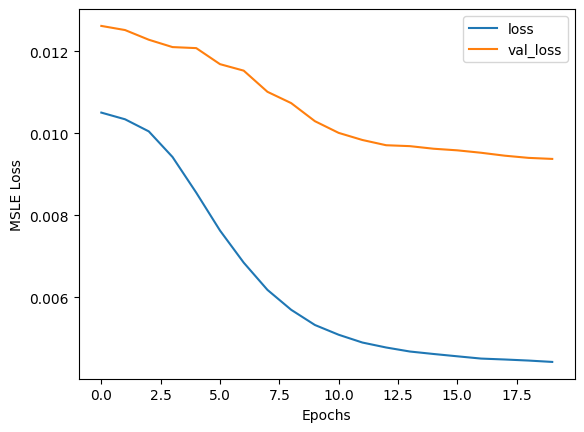

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('MSLE Loss')
plt.legend(['loss', 'val_loss'])
plt.show()

## Find threshold

In [ ]:
def find_threshold(model, x_train_scaled):
  reconstructions = model.predict(x_train_scaled)
  # provides losses of individual instances
  reconstruction_errors = tf.keras.losses.msle(reconstructions, x_train_scaled)

  # threshold for anomaly scores
  threshold = np.mean(reconstruction_errors.numpy()) \
      + np.std(reconstruction_errors.numpy())
  return threshold

def find_threshold_method_two(model, x_train_scaled):
  # another method to find threshold
  reconstructions = model.predict(x_train_scaled)
  # provides losses of individual instances
  reconstruction_errors = tf.keras.losses.msle(reconstructions, x_train_scaled)

  threshold_2 = np.percentile(reconstruction_errors, 95)
  return threshold_2

def get_predictions(model, x_test_scaled, threshold):
  predictions = model.predict(x_test_scaled)
  # provides losses of individual instances
  errors = tf.keras.losses.msle(predictions, x_test_scaled)
  # 0 = anomaly, 1 = normal
  anomaly_mask = pd.Series(errors) > threshold
  preds = anomaly_mask.map(lambda x: 0.0 if x == True else 1.0)
  return preds

In [ ]:
threshold = find_threshold(model, x_train_scaled)
print(f"Threshold method one: {threshold}")

threshold_2 = find_threshold_method_two(model, x_train_scaled)
print(f"Threshold method two: {threshold_2}")

73/73 [==============================] - 0s 1ms/step
Threshold method one: 0.009739066739668862
73/73 [==============================] - 0s 2ms/step
Threshold method two: 0.013627172249627673


In [ ]:
preds = get_predictions(model, x_test_scaled, threshold)
accuracy_score(preds, y_test)

32/32 [==============================] - 0s 2ms/step


0.938

## Tuning AutoEncoder using keras tuner



In [ ]:
!pip install -U keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.5/129.5 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 23.7 MB/s eta 0:00:00


In [ ]:
import kerastuner as kt

class AutoEncoderTuner(Model):

  def __init__(self, hp, output_units, code_size=8):
    super().__init__()
    dense_1_units = hp.Int('dense_1_units', min_value=16, max_value=72, step=4)
    dense_2_units = hp.Int('dense_2_units', min_value=16, max_value=72, step=4)
    dense_3_units = hp.Int('dense_3_units', min_value=16, max_value=72, step=4)
    dense_4_units = hp.Int('dense_4_units', min_value=16, max_value=72, step=4)
    dense_5_units = hp.Int('dense_5_units', min_value=16, max_value=72, step=4)
    dense_6_units = hp.Int('dense_6_units', min_value=16, max_value=72, step=4)

    self.encoder = Sequential([
      Dense(dense_1_units, activation='relu'),
      Dropout(0.1),
      Dense(dense_2_units, activation='relu'),
      Dropout(0.1),
      Dense(dense_3_units, activation='relu'),
      Dropout(0.1),
      Dense(code_size, activation='relu')
    ])
    self.decoder = Sequential([
      Dense(dense_4_units, activation='relu'),
      Dropout(0.1),
      Dense(dense_5_units, activation='relu'),
      Dropout(0.1),
      Dense(dense_6_units, activation='relu'),
      Dropout(0.1),
      Dense(output_units, activation='sigmoid')
    ])

  def call(self, inputs):
    encoded = self.encoder(inputs)
    decoded = self.decoder(encoded)
    return decoded


def build_model(hp):
  model = AutoEncoderTuner(hp, 140)
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
  model.compile(
      loss='msle',
      optimizer=Adam(learning_rate=hp_learning_rate),
  )
  return model

Using TensorFlow backend


<ipython-input-13-7e9dbe812728>:1: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  import kerastuner as kt


In [ ]:
tuner = kt.Hyperband(
    build_model,
    objective='val_loss',
    max_epochs=20,
    factor=3,
    directory='autoencoder',
    project_name='tuning_autoencoder6'
)

tuner.search(
    x_train_scaled,
    x_train_scaled,
    epochs=20,
    batch_size=512,
    validation_data=(x_test_scaled, x_test_scaled)
)

Trial 30 Complete [00h 00m 13s]
val_loss: 0.012132286094129086

Best val_loss So Far: 0.0080333286896348
Total elapsed time: 00h 02m 27s


In [ ]:
hparams = [f'dense_{i}_units' for i in range(1,7)] + ['learning_rate']
best_hyperparams = tuner.get_best_hyperparameters()
for hps in hparams:
  print(f"{hps}: {best_hyperparams[0][hps]}")

dense_1_units: 32
dense_2_units: 56
dense_3_units: 56
dense_4_units: 52
dense_5_units: 60
dense_6_units: 44
learning_rate: 0.01


In [ ]:
best_model = tuner.get_best_models()[0]
best_model.compile(loss='msle', optimizer=Adam(0.001))

best_model.fit(
    x_train_scaled,
    x_train_scaled,
    epochs=20,
    batch_size=512,
    validation_data=(x_test_scaled, x_test_scaled)
)

Epoch 1/20
5/5 [==============================] - 5s 78ms/step - loss: 0.0027 - val_loss: 0.0082
Epoch 2/20
5/5 [==============================] - 0s 16ms/step - loss: 0.0026 - val_loss: 0.0081
Epoch 3/20
5/5 [==============================] - 0s 21ms/step - loss: 0.0026 - val_loss: 0.0081
Epoch 4/20
5/5 [==============================] - 0s 19ms/step - loss: 0.0026 - val_loss: 0.0081
Epoch 5/20
5/5 [==============================] - 0s 17ms/step - loss: 0.0026 - val_loss: 0.0082
Epoch 6/20
5/5 [==============================] - 0s 18ms/step - loss: 0.0026 - val_loss: 0.0081
Epoch 7/20
5/5 [==============================] - 0s 17ms/step - loss: 0.0026 - val_loss: 0.0082
Epoch 8/20
5/5 [==============================] - 0s 23ms/step - loss: 0.0026 - val_loss: 0.0082
Epoch 9/20
5/5 [==============================] - 0s 18ms/step - loss: 0.0026 - val_loss: 0.0082
Epoch 10/20
5/5 [==============================] - 0s 18ms/step - loss: 0.0026 - val_loss: 0.0082
Epoch 11/20
5/5 [============

In [ ]:
threshold_ = find_threshold(best_model, x_train_scaled)
preds_ = get_predictions(best_model, x_test_scaled, threshold_)
accuracy_score(preds_, y_test)

32/32 [==============================] - 0s 2ms/step


0.942